## Starting EDA and Data Transformation

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import nltk
import re
import string as s

from nltk.corpus import stopwords
from datasets import Dataset


from transformers import BertTokenizer
from wordcloud import WordCloud

from transformers import AdamW, get_scheduler
from torch.optim import Adam
import torch

from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text  import TfidfVectorizer
from transformers import BertForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig

## Loading the dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jatinsareen/ag-news-classification-data")

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ag-news-classification-data/train.csv
/kaggle/input/ag-news-classification-data/test.csv


In [4]:
# Load the dataset
train_data = pd.read_csv('/kaggle/input/ag-news-classification-data/train.csv', header=0, names=['class_index', 'title', 'description'])
test_data = pd.read_csv('/kaggle/input/ag-news-classification-data/test.csv', header=0, names=['class_index', 'title', 'description'])

In [5]:
train_data.head()

,class_index,title,description
0,1,Explosion Rocks Baghdad Neighborhood,"BAGHDAD, Iraq, August 24 -- A car bomb explode..."
1,1,BBC reporters' log,BBC correspondents record events in the Middle...
2,1,Israel welcomes Rice nomination; Palestinians ...,Israel on Tuesday warmly welcomed the naming o...
3,1,Medical Journal Calls for a New Drug Watchdog,Medical researchers said the U.S. needs a syst...
4,1,Militants Kidnap Relatives of Iraqi Minister-TV,Militants have kidnapped two relatives of Iraq...


In [6]:
test_data.head()

,class_index,title,description
0,1,Large Explosion Heard in Central Baghdad (Reut...,Reuters - A large blast was heard in central\B...
1,1,Israel OKs More West Bank Settlement Homes,"JERUSALEM Aug. 23, 2004 - Israel announced pla..."
2,1,Scores of Iraqis die in 3 days of attacks,US troops fought a gunbattle with insurgents a...
3,1,At least 20 dead in Kurkik bombing,A suicide attacker detonated a car bomb near a...
4,1,"Israel, Egypt in Prisoner Swap",CAIRO (Reuters) - Israel released six Egyptia...


In [7]:
print(train_data.shape)

(20000, 3)


In [8]:
print(test_data.shape)

(1300, 3)


In [9]:
# Display basic info about the training set
print("Training Set Info:")
print(train_data.info())

Training Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  20000 non-null  int64 
 1   title        20000 non-null  object
 2   description  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB
None


In [10]:
# Display basic info about the testing set
print("Testing Set Info:")
print(test_data.info())

Testing Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  1300 non-null   int64 
 1   title        1300 non-null   object
 2   description  1300 non-null   object
dtypes: int64(1), object(2)
memory usage: 30.6+ KB
None


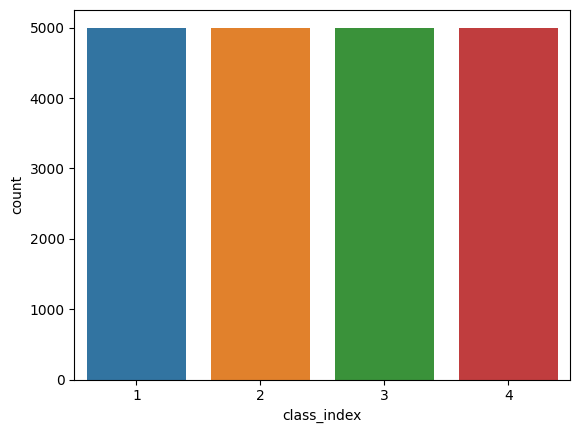

In [11]:
#Countplot of class_index column in Train Data
sns.countplot(x = 'class_index', data = train_data)
plt.show()

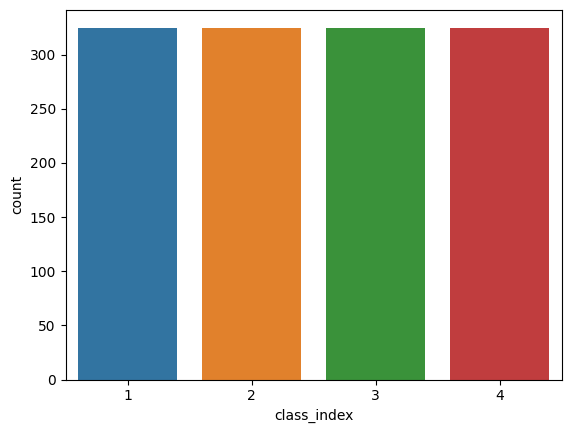

In [12]:
#Countplot of class_index column in Test Data
sns.countplot(x = 'class_index', data = test_data)
plt.show()

## Preparing Data For a News Classification
**Train_x and test_x represent the descriptions of news articles from training and testing datasets, respectively, whereas train_y and test_y represent the associated IDs or labels of the news articles for training and testing**

In [13]:
train_x = train_data.title + " " + train_data.description
test_x = test_data.title + " " + test_data.description
train_y = train_data.class_index
test_y = test_data.class_index

In [14]:
train_y = train_y - 1
test_y = test_y - 1

In [15]:
print(test_x)

0       Large Explosion Heard in Central Baghdad (Reut...
1       Israel OKs More West Bank Settlement Homes JER...
2       Scores of Iraqis die in 3 days of attacks US t...
3       At least 20 dead in Kurkik bombing A suicide a...
4       Israel, Egypt in Prisoner Swap  CAIRO (Reuters...
                              ...                        
1295    AMD et Chartered signent des contrats d #39;ap...
1296    REVIEW: New IMac G5 Short on Extras (AP) AP - ...
1297    Oil Company on Trial in Madagascar Over Pollut...
1298    Microsoft Takes Lead in PDA Software Microsoft...
1299    E.U. Regulators Approve Oracle's PeopleSoft Bi...
Length: 1300, dtype: object


## Word Cloud Visualization
**I did used the Word Cloud library to produce description data for news articles tagged with ID 1 in the training dataset, and then displays the resulting word cloud plot**


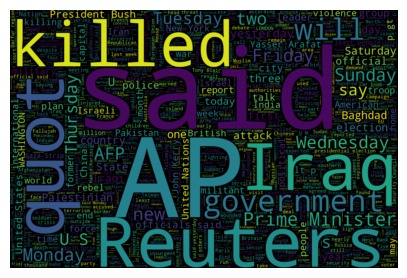

In [16]:
world = train_data[train_data['class_index'] == 1]['description']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(world))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**I did generates a word cloud visualization for descriptions of news articles labeled "sports" in the training data**

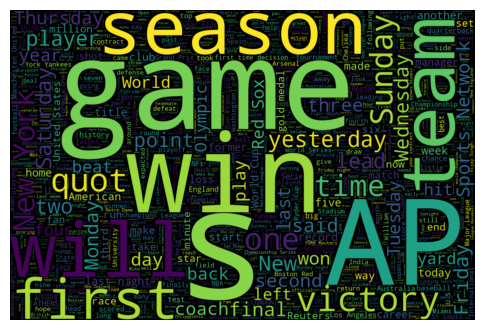

In [17]:
sports_desc = train_data.loc[train_data['class_index'] == 2, 'description']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sports_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Using the training data, I created a word cloud representation to describe a firm with ID 3, with the magnitude of each term equal to its frequency in the description**

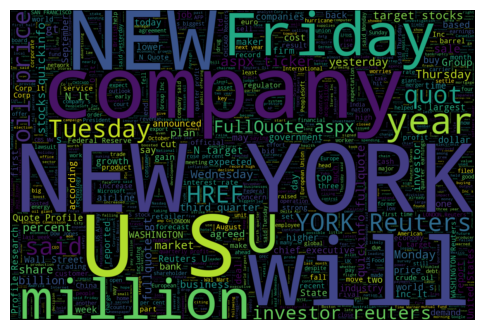

In [18]:
biz_desc = train_data.loc[train_data['class_index'] == 3, 'description']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(biz_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**I've been creating a word cloud image of the descriptions of scientific news articles with an ID of four from my training database**

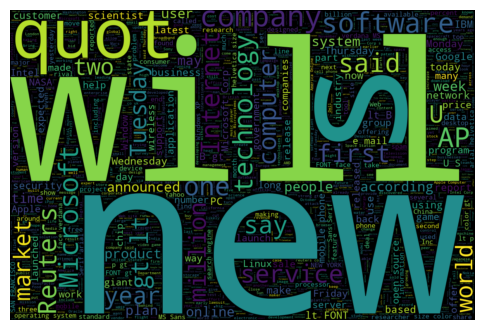

In [19]:
sci_desc = train_data.loc[train_data['class_index'] == 4, 'description']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sci_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Removing Tags


In [21]:
def remove_html_tag(text):
    html = re.compile('<.*?')
    cleaned_text = html.sub('', text)
    return cleaned_text
train_x = train_x.apply(remove_html_tag)
test_x = test_x.apply(remove_html_tag)

## Removing URL's

In [ ]:
def url_remove(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
train_x = train_x.apply(url_remove)
test_x = test_x.apply(url_remove)

## Tokenization


In [ ]:
def word_tokenize(text):
    token = re.findall("[\w']+", text)
    return token
train_x = train_x.apply(word_tokenize)
test_x = test_x.apply(word_tokenize)

## LowerCase

In [ ]:
train_x = train_x.apply(lambda x: [word.lower() for word in x])
test_x = test_x.apply(lambda x: [word.lower() for word in x])

## Removing StopWords


In [ ]:
def remove_stopwords(lst):
    stop_words = set(stopwords.words('english'))
    return [word for word in lst if word.lower() not in stop_words]
train_x = train_x.apply(remove_stopwords)
test_x = test_x.apply(remove_stopwords)

## Removing Punctuation


In [ ]:
import string
def remove_punctuations(lst):
    return [''.join(char for char in word if char not in string.punctuation) for word in lst]
train_x = train_x.apply(remove_punctuations)
test_x = test_x.apply(remove_punctuations)

## Removing Numbers

In [ ]:
def remove_number(lst):
    return [''.join(char for char in word if char not in string.digits) for word in lst if word]
train_x = train_x.apply(remove_number)
test_x = test_x.apply(remove_number)

## Stemming


In [ ]:
from nltk.stem import PorterStemmer
def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]
train_x = train_x.apply(stemming)
test_x = test_x.apply(stemming)

## Removing ExtraWords


In [ ]:
def remove_extra_words(word_list):
    stopwords = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    cleaned_list = []
    for word in word_list:
        if word not in stopwords:
            cleaned_list.append(word)
    return cleaned_list
train_x = train_x.apply(remove_extra_words)
test_x = test_x.apply(remove_extra_words)

## join_words_with_space
**I've defined a function called join_words_with_space that takes a list of words that appear to constitute sentences and connects them together in one string, with spaces between each word. Then, this function is applied to each element in the train_x and test_x datasets, converting any sentence from a list of words into a single string with spaces between them**

In [ ]:
def join_words_with_space(sentence):
    joined_sentence = ' '.join(sentence)
    return joined_sentence

train_x = train_x.apply(join_words_with_space)
test_x = test_x.apply(join_words_with_space)

## BERT Fine-Tuning

In [ ]:
# Convert train and test data into Hugging Face Dataset format
train_dataset = Dataset.from_dict({'text': train_x.tolist(), 'label': train_y.tolist()})
test_dataset = Dataset.from_dict({'text': test_x.tolist(), 'label': test_y.tolist()})

In [ ]:
# Accessing elements:
print(train_dataset[0]) 

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Define a tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

In [ ]:
# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [ ]:
num_labels = 4  # AG News has 4 classes
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=1000
)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
# Start training
trainer.train()

In [ ]:
results = trainer.evaluate()
print(f"BERT Test Loss: {results}")

## S-BERT (Sentence BERT) Fine-Tuning

In [ ]:
# Convert train and test data into Hugging Face Dataset format
train_dataset = Dataset.from_dict({'text': train_x.tolist(), 'label': train_y.tolist()})
test_dataset = Dataset.from_dict({'text': test_x.tolist(), 'label': test_y.tolist()})

In [ ]:
# Accessing elements:
print(train_dataset[0]) 

In [ ]:
# Load SBERT tokenizer and model
sbert_model_name = 'sentence-transformers/all-mpnet-base-v2'
tokenizer = AutoTokenizer.from_pretrained(sbert_model_name)
model = AutoModelForSequenceClassification.from_pretrained(sbert_model_name, num_labels=4)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_sbert",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs_sbert",
    logging_steps=1000
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
# Train the model
trainer.train()

In [ ]:
results = trainer.evaluate()
print(f"SBERT Test Loss: {results}")

## ALBERT Fine-Tuning

In [ ]:
# Convert train and test data into Hugging Face Dataset format
train_dataset = Dataset.from_dict({'text': train_x.tolist(), 'label': train_y.tolist()})
test_dataset = Dataset.from_dict({'text': test_x.tolist(), 'label': test_y.tolist()})

In [ ]:
# Accessing elements:
print(train_dataset[0]) 

In [ ]:
albert_model_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(albert_model_name)
model = AlbertForSequenceClassification.from_pretrained(albert_model_name, num_labels=4)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_albert",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs_albert",
    logging_steps=1000
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
# Train the model
trainer.train()

In [ ]:
results = trainer.evaluate()
print(f"ALBERT Test Loss: {results}")

## XLNET Fine-Tuning

In [ ]:
# Convert train and test data into Hugging Face Dataset format
train_dataset = Dataset.from_dict({'text': train_x.tolist(), 'label': train_y.tolist()})
test_dataset = Dataset.from_dict({'text': test_x.tolist(), 'label': test_y.tolist()})

In [ ]:
# Accessing elements:
print(train_dataset[0]) 

In [ ]:
xlnet_model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(xlnet_model_name)
model = XLNetForSequenceClassification.from_pretrained(xlnet_model_name, num_labels=4)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_xlnet",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs_xlnet",
    logging_steps=1000
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
# Start training
trainer.train()

In [ ]:
results = trainer.evaluate()
print(f"XLNet Test Loss: {results}")

## RoBERTa Fine-Tuning

In [ ]:
# Convert train and test data into Hugging Face Dataset format
train_dataset = Dataset.from_dict({'text': train_x.tolist(), 'label': train_y.tolist()})
test_dataset = Dataset.from_dict({'text': test_x.tolist(), 'label': test_y.tolist()})

In [ ]:
# Accessing elements:
print(train_dataset[0])

In [ ]:
roberta_model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
model = RobertaForSequenceClassification.from_pretrained(roberta_model_name, num_labels=4)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_roberta",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs_roberta",
    logging_steps=1000
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
# Start training
trainer.train()

In [ ]:
results = trainer.evaluate()
print(f"RoBERTa Test Loss: {results}")

### Finally, Out of all the trained models, we are getting much less loss for Roberta model.So, We will FineTune the RoberTa model on top of our Dataset.

In [20]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {
        "accuracy": accuracy,
        "f1": f1,
    }

In [21]:
# Convert train and test data into Hugging Face Dataset format
train_dataset = Dataset.from_dict({'text': train_x.tolist(), 'label': train_y.tolist()})
test_dataset = Dataset.from_dict({'text': test_x.tolist(), 'label': test_y.tolist()})

In [22]:
# Accessing elements:
print(train_dataset[0])

{'text': 'Explosion Rocks Baghdad Neighborhood BAGHDAD, Iraq, August 24 -- A car bomb exploded near the gate of a US-funded Iraqi television network in Baghdad on Tuesday, killing at least two people and wounding two others, authorities and witnesses said.', 'label': 0}


In [23]:
roberta_model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
model = RobertaForSequenceClassification.from_pretrained(roberta_model_name, num_labels=4)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Freeze the first few layers
for param in model.roberta.embeddings.parameters():
    param.requires_grad = False
for i, layer in enumerate(model.roberta.encoder.layer):
    if i < 4:  # Freeze layers 0-3, adjust as needed
        for param in layer.parameters():
            param.requires_grad = False

In [25]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

In [26]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1300 [00:00<?, ? examples/s]

In [28]:
training_args = TrainingArguments(
    output_dir="./results_roberta",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.1,
    logging_dir="./logs_roberta",
    logging_steps=1000,
    save_strategy="epoch",
    save_total_limit=7,
    load_best_model_at_end=True
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [30]:
# Start training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.362800,0.255007,0.920000,0.919895
2,0.235700,0.245202,0.930000,0.930227
3,0.198000,0.242019,0.932308,0.932278
4,0.152700,0.251490,0.939231,0.939524
5,0.131500,0.289608,0.940000,0.940095
6,0.117300,0.321699,0.935385,0.935237
7,0.093900,0.350767,0.940769,0.940763
8,0.065200,0.382824,0.942308,0.942486
9,0.050100,0.475771,0.930769,0.931007
10,0.044400,0.460132,0.943077,0.943158


TrainOutput(global_step=62500, training_loss=0.035061499312162396, metrics={'train_runtime': 9870.6703, 'train_samples_per_second': 101.31, 'train_steps_per_second': 6.332, 'total_flos': 6.5778945024e+16, 'train_loss': 0.035061499312162396, 'epoch': 50.0})

In [31]:
results = trainer.evaluate()
print(f"RoBERTa Test Accuracy: {results['eval_accuracy']}")

RoBERTa Test Accuracy: 0.9323076923076923


In [32]:
output_dir="/kaggle/working/final_model"

In [33]:
# Save the model
trainer.model.save_pretrained(output_dir)

In [34]:
# Save the tokenizer
tokenizer.save_pretrained(output_dir)

('/kaggle/working/final_model/tokenizer_config.json',
 '/kaggle/working/final_model/special_tokens_map.json',
 '/kaggle/working/final_model/vocab.json',
 '/kaggle/working/final_model/merges.txt',
 '/kaggle/working/final_model/added_tokens.json')

In [35]:
# Load the model and tokenizer from the output directory
model = RobertaForSequenceClassification.from_pretrained(output_dir)
tokenizer = RobertaTokenizer.from_pretrained(output_dir)

In [36]:
# Example text data
texts = ["US stocks fell as setbacks for drugmakers, including a study showing Pfizer Inc. #39;s Celebrex painkiller increased the risk of heart attacks, sent health-care shares tumbling.", "Lloyds TSB is gearing up to roll out one of the largest converged networks in Europe, a 500m 70,000 phone VoIP infrastructure linking all the bank #39;s branches and cash "]

In [37]:
# Tokenize and prepare data for model input
inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

In [38]:
# Move the model to evaluation mode and disable gradient calculation
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

In [39]:
# Convert logits to predicted class indices
predicted_class_ids = torch.argmax(logits, dim=1)

# If you want class labels, you can map these ids back to labels
id2label = model.config.id2label  # Should contain {0: "label1", 1: "label2", ...}
predicted_labels = [id2label[id.item()] for id in predicted_class_ids]

print(predicted_labels)

['LABEL_2', 'LABEL_3']


In [40]:
def predict_texts(texts, model, tokenizer):
    # Tokenize inputs
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Process logits to get predicted labels
    predicted_class_ids = torch.argmax(logits, dim=1)
    id2label = model.config.id2label
    predicted_labels = [id2label[id.item()] for id in predicted_class_ids]
    
    return predicted_labels

In [41]:
predict_texts([" DETROIT (Reuters) - Protests from seven safety groups  prompted General Motors Corp. to pull a television ad that  shows a young boy driving a Corvette sports car so "],model,tokenizer)

['LABEL_2']

In [42]:
predict_texts(["POPE John Paul today issued a new appeal for peace in Iraq and the Middle East, condemning the  quot;horror quot; of violence as well as  quot;the terrorism that cruelly targets the innocent quot;."],model,tokenizer)

['LABEL_0']

In [43]:
predict_texts(["NEW YORK : New York Attorney General Eliot Spitzer sued Thursday a major US insurance brokerage firm, Marsh and McLennan Co, for steering clients to insurers with whom it had lucrative payoff agreements."],model,tokenizer)

['LABEL_2']

In [44]:
predict_texts(["Johannesburg, 7 October 2004 - Computer Associates International, Inc (NYSE: CA) today announced general availability of eTrust Antivirus for Microsoft Windows XP Embedded - the industry #39;s first virus protection solution designed specifically for "],model,tokenizer)

['LABEL_3']

In [45]:
predict_texts(["The legal battle for control of Formula One gets underway in earnest today, with Bernie Ecclestone and the three German banks that make up the major shareholding in the sport going to court to decide who has the right to power."],model,tokenizer)

['LABEL_1']

In [46]:
import shutil
from IPython.display import FileLink

# Zip the final_model directory
shutil.make_archive("/kaggle/working/final_model", 'zip', "final_model")

/kaggle/working/final_model.zip